Importing labels

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# File path subject 2
file_path = 'dataset_phase1_ntx23/train_S002_labeled.csv'
# Read the data
df = pd.read_csv(file_path)


In [62]:
df.dtypes 

Timestamp    int64
Epochs       int64
SS1          int64
SS0          int64
K1           int64
K0           int64
REM1         int64
REM0         int64
Son1         int64
Son0         int64
Soff1        int64
Soff0        int64
A1           int64
A0           int64
MS1          int64
MS0          int64
dtype: object

In [63]:
df.shape

(1191, 16)

Importing the EEG data

In [64]:
from scipy.signal import butter, filtfilt

# Extract more features (example: spectral features)
from scipy.signal import welch

# Function to apply bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

# Function to normalize data
def normalize_data(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    normalized_data = (data - mean) / std
    return normalized_data

def extract_spectral_features(data_epochs, fs=250):
    spectral_features = []
    for epoch_data in data_epochs:
        f, Pxx = welch(epoch_data, fs=fs, nperseg=64)  # Adjust parameters as needed
        spectral_features.append(Pxx)
    return np.array(spectral_features)

# Extract spectral features
spectral_features = extract_spectral_features(data_epochs)


In [65]:
import mne
import os
from scipy.io import loadmat

# Replace with the path to your .mat file containing EEG data
mat_file_path = 'dataset_phase1_ntx23/train_S002_night1_hackathon_filt.mat'

# Load the .mat file using scipy
mat = loadmat(mat_file_path)

# Extract EEG data
eeg_data = mat['EEG'][0, 0]['data']

# Apply bandpass filter
filtered_data = bandpass_filter(eeg_data, lowcut=0.75, highcut=35, fs=250)

# Normalize the filtered data
normalized_data = normalize_data(filtered_data)

# Create an MNE Info object, necessary to create RawArray
info = mne.create_info(ch_names=['EEG1', 'EEG2'], sfreq=250, ch_types=['eeg', 'eeg'])

# Create the RawArray object
raw = mne.io.RawArray(eeg_data, info)

# Now you can plot the raw data, create epochs, etc., using MNE functions.


Creating RawArray with float64 data, n_channels=2, n_times=4965399
    Range : 0 ... 4965398 =      0.000 ... 19861.592 secs
Ready.


In [66]:
# Inspect the loaded data
print(raw)
print(raw.info)


<RawArray | 2 x 4965399 (19861.6 s), ~75.8 MB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: EEG1, EEG2
 chs: 2 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 2
 projs: []
 sfreq: 250.0 Hz
>


In [67]:
# Get the data from the raw object
data = raw.get_data()

# Splice data to match labels
data_snapshot = data[:, df['Timestamp'].iloc[0]:df['Timestamp'].iloc[-1]]

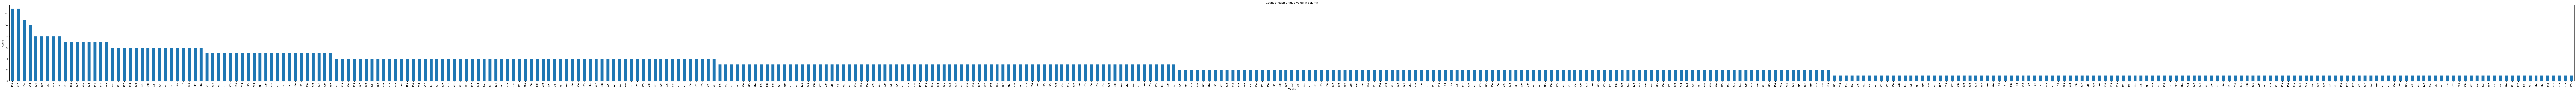

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(200,6))

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column
# you're interested in:

# Count the occurrence of each unique value in the column
value_counts = df['Epochs'].value_counts()

# Create a bar chart
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Count of each unique value in column')

plt.xticks(rotation=90)

# Display the plot
plt.show()


In [69]:
sorted_df = df.sort_values(by=['Epochs'])
sorted_df = sorted_df.sort_values(by=['Timestamp'])
sorted_df = sorted_df.reset_index(drop=True)


In [70]:
sorted_df

,Timestamp,Epochs,SS1,SS0,K1,K0,REM1,REM0,Son1,Son0,Soff1,Soff0,A1,A0,MS1,MS0
0,8644,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,9770,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,11064,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,12266,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,13515,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,4858485,648,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1187,4859080,648,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1188,4859551,648,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1189,4861151,649,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [71]:
data_epochs = []

In [72]:
for epoch in np.unique(sorted_df['Epochs'].values):
    idxs = np.where(sorted_df['Epochs'] == epoch)[0]

    for idx in idxs:
        timestamp = sorted_df.iloc[idx]['Timestamp']
        data_snapshot = data[:, (timestamp - int(1*250)):timestamp] # Takes 1 second of data before the timestamp to until the timestamp
        data_epochs.append(data_snapshot)

In [73]:
data_epochs = np.array(data_epochs)

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Reshape data_epochs.mean(-1) to maintain its second dimension
neural_data = data_epochs.mean(-1).reshape(data_epochs.shape[0], -1)

# Flattens spectral_features based on its structure
# Flattening if it has 3 dimensions
spectral_features_flat = spectral_features.reshape(spectral_features.shape[0], -1)

# Reshape data_epochs.mean(-1) to maintain its second dimension
neural_data = data_epochs.mean(-1).reshape(data_epochs.shape[0], -1)

# Reshape or flatten spectral_features based on its structure, if it has 3 dimensions
spectral_features_flat = spectral_features.reshape(spectral_features.shape[0], -1)

# Combine features
X = np.concatenate([neural_data, spectral_features_flat], axis=1)
y = sorted_df.drop(columns=['Timestamp', 'Epochs'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5857740585774058
